In [7]:
# =========================
# TRAIN CATBOOST + PREDICTION
# =========================
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
import joblib

In [8]:

# -------------------------
# Paramètres
# -------------------------
TRAIN_FILE = "./ressources/npyDS/DataSetTestOptimized/train_optimized_traintest.csv"
VAL_FILE   = "./ressources/npyDS/DataSetTestOptimized/val_traintest.csv"
TEST_FILE  = "./ressources/npyDS/DataSetTestOptimized/test_optimized_traintest.csv"
SUBMISSION_FILE = "./ressources/results/CATBOOST_FromTest_Huber.csv"
MODEL_FILE = "./ressources/models/catboost_model_FromTest_Huber.joblib"
Y_NAME = "y"

EARLY_STOPPING_ROUNDS = 50
NUM_ITERATIONS = 30000
RANDOM_STATE = 42

In [9]:

# -------------------------
# Chargement des données
# -------------------------
train_df = pd.read_csv(TRAIN_FILE)
val_df   = pd.read_csv(VAL_FILE)
test_df  = pd.read_csv(TEST_FILE)

y_train = train_df[Y_NAME].to_numpy()
X_train = train_df.drop(columns=[Y_NAME]).to_numpy()

y_val = val_df[Y_NAME].to_numpy()
X_val = val_df.drop(columns=[Y_NAME]).to_numpy()

X_test = test_df.to_numpy()

# -------------------------
# Pool CatBoost
# -------------------------
train_pool = Pool(X_train, label=y_train)
val_pool   = Pool(X_val, label=y_val)

In [10]:

# -------------------------
# Modèle CatBoost
# -------------------------
# model = CatBoostRegressor(
#     iterations=NUM_ITERATIONS,          # plus d'arbres
#     learning_rate=0.02,      # plus petit pour précision
#     depth=6,                  # arbres plus profonds
#     l2_leaf_reg=3,            # régularisation plus forte
#     subsample=0.8,            # sample fraction pour éviter overfit
#     colsample_bylevel=0.8,    # feature fraction
#     loss_function= 'LogCosh',
#     eval_metric='LogCosh',
#     random_seed=42,
#     od_type='Iter',
#     od_wait=100,              # early stopping
#     verbose=500,              # affiche toutes les 100 itérations
#     task_type='CPU'
# )
#
# model = CatBoostRegressor(
#     iterations=NUM_ITERATIONS,          # plus d'arbres
#     learning_rate=0.09635353719505078,      # plus petit pour précision
#     depth=8,                  # arbres plus profonds
#     l2_leaf_reg=3,            # régularisation plus forte
#     subsample=0.7501378731997537,            # sample fraction pour éviter overfit
#     colsample_bylevel=0.699465114153671,    # feature fraction
#     loss_function= 'LogCosh',
#     eval_metric='LogCosh',
#     random_seed=42,
#     od_type='Iter',
#     od_wait=100,              # early stopping
#     verbose=500,              # affiche toutes les 100 itérations
#     task_type='CPU'
# )

model = CatBoostRegressor(
    iterations=NUM_ITERATIONS,          # plus d'arbres
    learning_rate=0.037131908555001,      # plus petit pour précision
    depth=8,                  # arbres plus profonds
    l2_leaf_reg=8,            # régularisation plus forte
    subsample=0.9481957612344127,            # sample fraction pour éviter overfit
    colsample_bylevel=0.6774015121344121,    # feature fraction
    loss_function = "Huber:delta=0.05",
    eval_metric = "MAE",
    random_seed=42,
    od_type='Iter',
    od_wait=100,              # early stopping
    verbose=500,              # affiche toutes les 100 itérations
    task_type='CPU'
)



#'depth': 8, 'learning_rate': 0.09951832311578027, 'l2_leaf_reg': 8, 'subsample': 0.998037056444162, 'colsample_bylevel': 0.8783844219067578
#RMSE : 0.0491 | MAE: 0.0345 | R²: 0.9439

#Meilleurs paramètres : {'depth': 8, 'learning_rate': 0.08595352773761343, 'l2_leaf_reg': 4, 'subsample': 0.9508099797377806, 'colsample_bylevel': 0.7943541814862287}

#Huber MAe : {'depth': 8, 'learning_rate': 0.037131908555001, 'l2_leaf_reg': 8, 'subsample': 0.9481957612344127, 'colsample_bylevel': 0.6774015121344121}

#Meilleurs paramètres : {'depth': 8, 'learning_rate': 0.09635353719505078, 'l2_leaf_reg': 3, 'subsample': 0.7501378731997537, 'colsample_bylevel': 0.699465114153671}

In [11]:

# -------------------------
# Entrainement avec early stopping
# -------------------------
model.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True
)

0:	learn: 5.1649579	test: 5.1350030	best: 5.1350030 (0)	total: 382ms	remaining: 3h 10m 51s
500:	learn: 0.1467452	test: 0.1481795	best: 0.1481786 (498)	total: 2m 25s	remaining: 2h 23m 3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1481784069
bestIteration = 502

Shrink model to first 503 iterations.


In [12]:

# -------------------------
# Sauvegarde du modèle
# -------------------------
joblib.dump(model, MODEL_FILE)

['./ressources/models/catboost_model_FromTest_Huber.joblib']

RMSE : 0.2056 | MAE: 0.1482 | R²: 0.0142


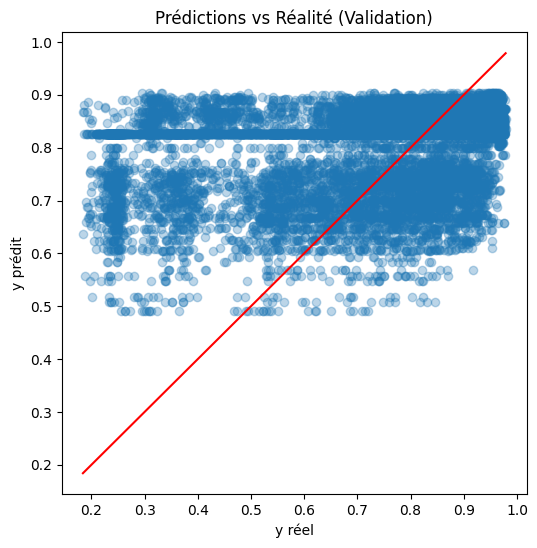

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# =========================
# 7. Évaluation finale
# =========================
y_val_pred = model.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f"RMSE : {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

plt.figure(figsize=(6,6))
plt.scatter(y_val, y_val_pred, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='r')
plt.xlabel("y réel")
plt.ylabel("y prédit")
plt.title("Prédictions vs Réalité (Validation)")
plt.show()

In [14]:

# -------------------------
# Prédiction sur test
# -------------------------
y_test_pred = model.predict(X_test)

# IDs depuis le dataset brut
df_test_raw = pd.read_csv("./ressources/test.csv")
ids = df_test_raw["id"]

# Création du CSV de submission
df_submission = pd.DataFrame({
    "id": ids,
    "wip": 0,
    "investissement": 0,
    "satisfaction": y_test_pred
})

df_submission.to_csv(SUBMISSION_FILE, index=False)

print(f"✅ Fichier {SUBMISSION_FILE} généré avec succès")

✅ Fichier ./ressources/results/CATBOOST_FromTest_Huber.csv généré avec succès
